In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=False, download=True, transform=transforms.ToTensor())

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 5

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=7, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=True, num_workers=7, pin_memory=use_cuda)

In [4]:
def nets(): 
    return nn.Sequential(nn.Conv2d(1, 1, kernel_size=1), 
                         nn.LeakyReLU(True), 
                         nn.Conv2d(1, 1, kernel_size=1), 
                         nn.LeakyReLU(True), 
                         nn.Conv2d(1, 1, kernel_size=1), 
                         nn.Sigmoid())
def nett():
    return nn.Sequential(nn.Conv2d(1, 1, kernel_size=1), 
                         nn.LeakyReLU(True), 
                         nn.Conv2d(1, 1, kernel_size=1), 
                         nn.LeakyReLU(True), 
                         nn.Conv2d(1, 1, kernel_size=1))

class CouplingLayer(nn.Module):
    def __init__(self, shape, first=True):
        super().__init__()
        size = shape[0] * shape[1]
        mask = np.zeros(shape) if first else np.ones(shape)
        mask[::2,::2] = first
        mask[1::2,1::2] = first
        self.mask1 = nn.Parameter(torch.from_numpy(np.array(mask).astype(np.float32)), requires_grad=False).to(device) 
        self.mask2 = (1 - self.mask1)
        self.translate = nett()
        self.scale = nets()

    def forward(self, args):
        if self.training: 
            x, log_det_J = args
        else:
            x = args
        x1 = x * self.mask1
        x2 = x * self.mask2
        s = self.scale(x1) * self.mask2
        t = self.translate(x1) * self.mask2
        y2 = x2 * torch.exp(s) + t
        y = x1 + y2
        if self.training:
            log_det_J += s.sum(dim=(1,2,3))
            return y, log_det_J
        return y

In [5]:
class RealNVP(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.size = shape[0] * shape[1] 
        self.prior = distributions.MultivariateNormal(torch.zeros(self.size, device=device), torch.eye(self.size, device=device))
        self.encoder = nn.Sequential(CouplingLayer(shape), 
                                     CouplingLayer(shape, False),
                                     CouplingLayer(shape), 
                                     CouplingLayer(shape, False),
                                     CouplingLayer(shape), 
                                     CouplingLayer(shape, False))
    
    def forward(self, x):
        return self.encoder(x)
    
    def backward(self, y):
        return self.encoder[::-1](y)
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize, 1))
        y = y.view(-1, 1, *self.shape)
        return self.backward(y)
    
    def log_prob(self, x):
        y, logp = self(x)
        y = y.view(-1, self.size)
        return self.prior.log_prob(y) + logp
        

In [6]:
def train(network):
    net = network(IM_SHAPE).to(device).train()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    for epoch in range(EPOCHS):
        for X, _ in trainset:
            X = X.to(device)
            optimizer.zero_grad()
            loss = -net.log_prob((X, X.new_zeros(X.shape[0]))).mean()
            loss.backward(retain_graph=True)
            optimizer.step()
        print(epoch, loss)
    
    return net

In [7]:
net_RealNVP = train(RealNVP)


0 tensor(5474.8896, device='cuda:0', grad_fn=<NegBackward>)
1 tensor(2637.7693, device='cuda:0', grad_fn=<NegBackward>)
2 tensor(1183.7385, device='cuda:0', grad_fn=<NegBackward>)
3 tensor(463.9425, device='cuda:0', grad_fn=<NegBackward>)
4 tensor(277.3551, device='cuda:0', grad_fn=<NegBackward>)


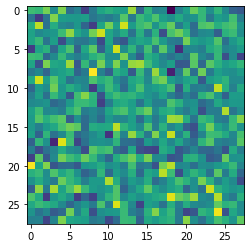

In [8]:
net_RealNVP.eval()
X = net_RealNVP.sample().cpu()
plt.imshow(X[0].view(IM_SHAPE).detach().numpy())

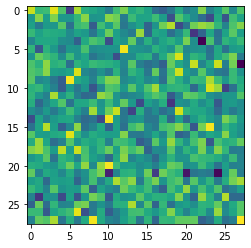

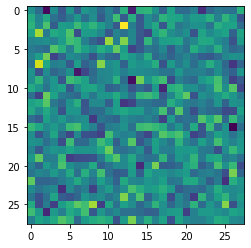

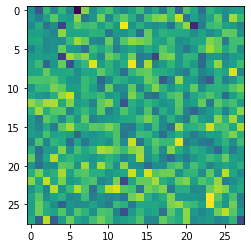

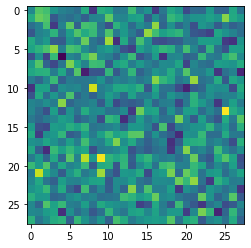

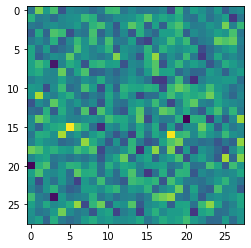

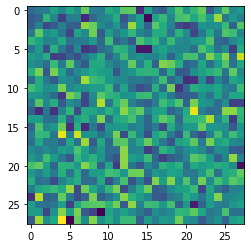

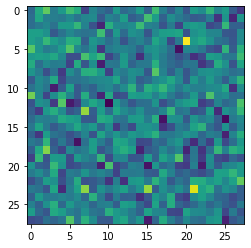

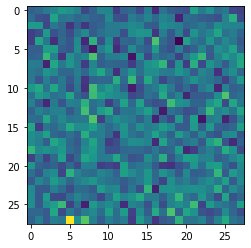

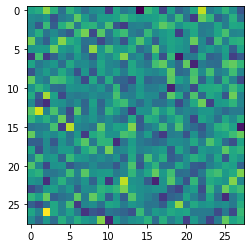

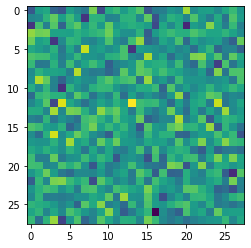

In [9]:
net_RealNVP.eval()
SAMPLES = 10
X = net_RealNVP.sample(SAMPLES).cpu()
for i in range(SAMPLES):
    plt.imshow(X[i].view(IM_SHAPE).detach().numpy())
    plt.show()
    